In [16]:
import sys
import xlrd
import pandas as pd
import numpy as np
from numpy import median
import os
import fnmatch 

INPUTS = '/Users/jiz225/Desktop/ZidLab/polarity/input' 
OUTPUTS = '/Users/jiz225/Desktop/ZidLab/polarity/outputcsv'
def makecsv(inputpath, outputpath):
    inputf = open(inputpath,'r')
    outputf = open(outputpath, 'w')
    outputf.write('Name'+ ',' + 'Orient' + ',' + 'Start' + ',' + 'End' + ',' + 'Position' + ',' +'Length' + ',' + 'RelativePosition' + ',' + 'Counts' + '\n')
    while True:
        line = inputf.readline()
        if not line:
            break
    
        string = line.rstrip() 
        cells = string.split('\t')
        name = cells[0][:7] 
        orient = cells[0][6:7]
        start = cells[1]
        end = cells[2]
        length = abs(int(start) - int(end))
        riboCount = cells[4]
        posit = cells[3]
        
        if orient == 'W':
            rposit = (int(cells[3])+1 - (int(start)))
    
        elif orient == "C":
            rposit = ((int(start))-(int(cells[3])-1))
            
        if rposit > 0 and rposit <(length-15):
            outputf.write(str(name) + ',' + str(orient) + ',' + str(start) + ',' + str(end) + ',' + str(posit) + ',' + str(length-15) + ',' + str(rposit) + ',' + str(riboCount) + '\n')
    inputf.close()
    outputf.close()
    
inputlist = []
outputlist = []
inputfolder = os.listdir(INPUTS)
extension = "*.xls"
for doc in inputfolder:
    if fnmatch.fnmatch(doc, extension):
        #change this input and ouput file path
        inputpath = str("/Users/jiz225/Desktop/ZidLab/polarity/input/") + doc
        namelist = doc.split('.')
        name = namelist[0]
        outputpath = str("/Users/jiz225/Desktop/ZidLab/polarity/outputcsv/") + name + str(".csv")
        inputlist.append(inputpath)
        outputlist.append(outputpath)
Gene_Polarity_all = []

In [17]:
%matplotlib inline
%pylab inline

import matplotlib.pyplot as plt
from itertools import accumulate
import numpy as np
import scipy.stats as stats
import pylab as pl

def calculatePolarity(i, l, densityati, density):
    normDist = (2*i - (l + 1))/(l - 1)
    polarity = densityati*normDist/density
    return polarity

def PolarityPerGene(inputpath):
    df1 = pd.read_csv(inputpath)
    names = inputpath.split('.')
    #this is the final output file
    nameofcsv = names[0] + str("_polarity&gene.csv")
    Namelist = df1['Name'].tolist()
    Countslist = df1['Counts'].tolist()
    Orientlist = df1['Orient'].tolist()
    Positionlist = df1['Position'].tolist()

    startp = 0
    for i in range (len(Namelist) - 1):
        if Namelist[i + 1] == Namelist[i]:
            Countslist[i + 1] += Countslist[i]
        else:
            for j in range (startp, i+1):
                Countslist[j] = Countslist[i]
            startp = i + 1
 
    df = pd.DataFrame({'col':Countslist})
    df1['TotalCounts'] = Countslist
    Totalcountlist = df1['TotalCounts'].tolist()
    Countsperilist = df1['Counts'].tolist()
    Lengthlist = df1['Length'].tolist()
    Positlist = df1['RelativePosition'].tolist()
    Polaritylist = []
    Genelist = []
    for i in range (len(Namelist)):
        polarityofi = calculatePolarity(Positlist[i], Lengthlist[i], Countsperilist[i], Totalcountlist[i])
        Polaritylist.append(polarityofi)
        newname = str(Namelist[i]) + str(Orientlist[i])
        Genelist.append(newname)
    df = pd.DataFrame({'col':Polaritylist})
    df1['Polarity'] = Polaritylist
    

    #calculate total polarity and ribosome occupancy
    Gene_Polarity = {}
    ribo = []
    geneP = df1['Polarity'].tolist()
    '''
    totalribo = 0
    for i in range (len(Namelist)):
        totalribo += Totalcountlist[i]
    for i in range (len(Namelist)): 
        ribo.insert(i, Totalcountlist[i] / totalribo)
    '''
    for i in range (len(Namelist) - 1):
        if Namelist[i + 1] == Namelist[i]:
            geneP[i + 1] += geneP[i]
            geneP[i] = -1000
        else:
            Gene_Polarity[Namelist[i]] = geneP[i]
    for i in range (len(Namelist)):
        if Totalcountlist[i] < 100:
            Totalcountlist[i] = -1000
        elif geneP[i] >= 1.0 or geneP[i] <= -1.0:
            geneP[i] = -1000
    df = pd.DataFrame({'col':geneP})
    df1['PolarityPerGene'] = geneP
    d = {'Name':Genelist, 'Position': Positionlist, 'Totalcount': Totalcountlist, 'PolarityPerGene': geneP}
    dfcsv = pd.DataFrame(data=d)
    dfcsv = dfcsv.replace(-1000, np.nan)
    dfcsv = dfcsv.dropna(how='any',axis=0)
    pslist = dfcsv['Position'].tolist()
    pllist = dfcsv['PolarityPerGene'].tolist()
    
    plt.plot(pslist, pllist)
    plt.ylabel('Polarity')
    plt.xlabel('Position')
    plt.show()
    
    pllist.sort()
    percentage = []
    x = 1/ int(len(pllist))
    for i in range(0, len(pllist)):
        percentage.insert(i, x)
        x += 1/ int(len(pllist))
    plt.plot(pllist, percentage)
    plt.ylabel('Cumulative Distribution(%)')
    plt.xlabel('Change in Polarity')
    plt.show()
    
    fit = stats.norm.pdf(pllist, np.mean(pllist), np.std(pllist))
    pl.plot(pllist,fit)
    pl.hist(pllist,normed=True)  
    pl.show()
    
    print('The Median is:' + str(pslist[np.argsort(pllist)[len(pllist)//2]]) + ',' + str(median(pllist)))
    

    #df1.to_csv(nameofcsv)
    dfcsv.to_csv(nameofcsv)
    return Gene_Polarity
    

Populating the interactive namespace from numpy and matplotlib


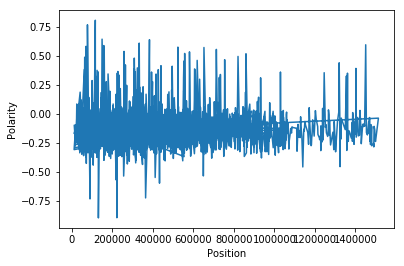

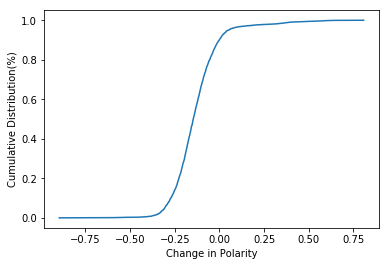

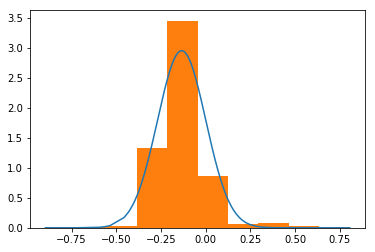

The Median is:130417,-0.146731074958


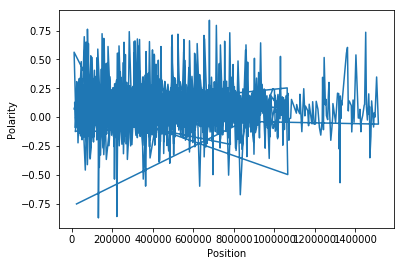

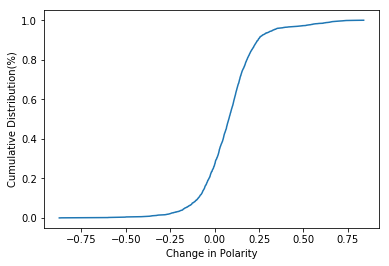

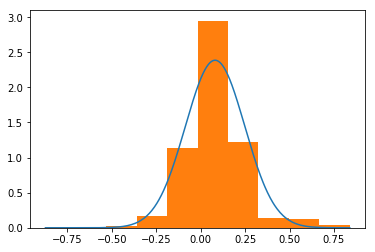

The Median is:147551,0.0805918200792


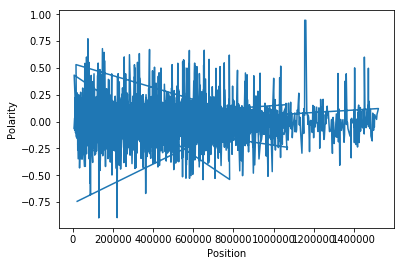

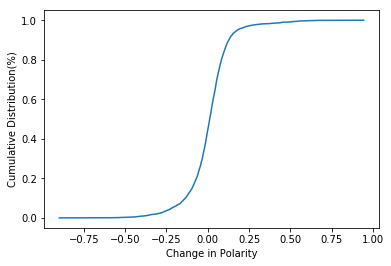

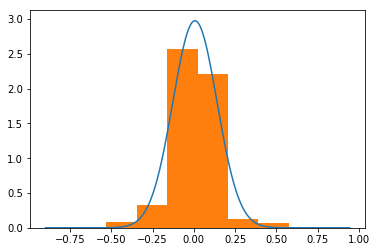

The Median is:305856,0.0118114607286


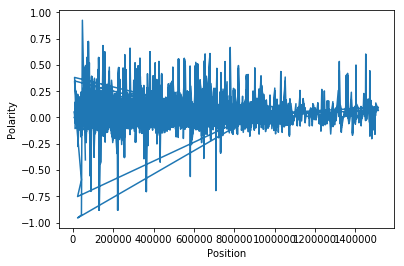

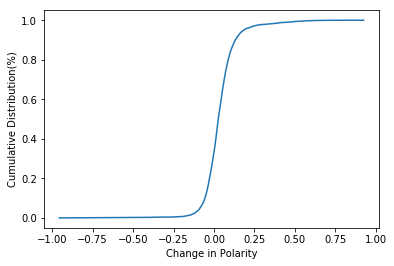

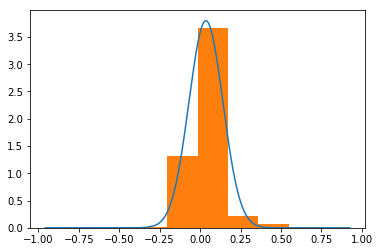

The Median is:162695,0.0267942575597

 Number of possible input files: 4

 Number of possible output csv files: 4


In [18]:
for i in range(0, len(inputlist)):
    makecsv(inputlist[i], outputlist[i])
    Gene_Polarity = PolarityPerGene(outputlist[i])
    Gene_Polarity_all.append(Gene_Polarity)
print('\n Number of possible input files: ' + str(len(inputlist)))
print('\n Number of possible output csv files: ' + str(len(outputlist)))